In [3]:
# # Mount google drive to acess datasets
# from google.colab import drive
# drive.mount('/content/drive')

# Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import os
import sys
from random import randrange
import scipy

import librosa # For analyzing audio and music, extracting the data from the audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio # To play the audio files

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
import concurrent.futures

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2024-06-25 15:49:43.273393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 15:49:43.273772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 15:49:43.422254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Datasets
We will use 4 datasets:
- Crema
- Ravdess
- Savee
- Tess

## RAVDESS Dataset

In [7]:
# # Define the path to the RAVDESS dataset in your Google Drive
# Ravdess = '/content/drive/MyDrive/Speech Emotion Recognition (en)/Ravdess/audio_speech_actors_01-24/'
# Kaggle path
Ravdess = "/kaggle/input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24"

# List directories in the RAVDESS dataset path
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    # List files for each actor in the directory
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0].split('-')
        # Third part in each file represents the emotion associated to that file
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))

# Create a dataframe for emotions of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create a dataframe for paths of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Replace integer labels with actual emotion names
Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

# Display the first few rows of the dataframe
Ravdess_df.head(20)

,Emotions,Path
0,surprise,/kaggle/input/speech-emotion-recognition-en/Ra...
1,neutral,/kaggle/input/speech-emotion-recognition-en/Ra...
2,disgust,/kaggle/input/speech-emotion-recognition-en/Ra...
3,disgust,/kaggle/input/speech-emotion-recognition-en/Ra...
4,neutral,/kaggle/input/speech-emotion-recognition-en/Ra...
5,fear,/kaggle/input/speech-emotion-recognition-en/Ra...
6,sad,/kaggle/input/speech-emotion-recognition-en/Ra...
7,neutral,/kaggle/input/speech-emotion-recognition-en/Ra...
8,calm,/kaggle/input/speech-emotion-recognition-en/Ra...
9,happy,/kaggle/input/speech-emotion-recognition-en/Ra...


## CREMA Dataset

In [12]:
# # Define the path to the CREMA dataset in your Google Drive
# Crema = '/content/drive/MyDrive/Speech Emotion Recognition (en)/Crema/'
# Kaggle Path
Crema = "/kaggle/input/speech-emotion-recognition-en/Crema"

# List directories in the CREMA dataset path
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # Storing file paths
    file_path.append(os.path.join(Crema, file))
    # Storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Crema_df.head(20)

,Emotions,Path
0,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
1,happy,/kaggle/input/speech-emotion-recognition-en/Cr...
2,happy,/kaggle/input/speech-emotion-recognition-en/Cr...
3,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
4,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
5,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
6,happy,/kaggle/input/speech-emotion-recognition-en/Cr...
7,sad,/kaggle/input/speech-emotion-recognition-en/Cr...
8,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
9,sad,/kaggle/input/speech-emotion-recognition-en/Cr...


## TESS Dataset

In [15]:
# # Define the path to the TESS dataset in your Google Drive
# Tess = '/content/drive/MyDrive/Speech Emotion Recognition (en)/Tess/'
# Kaggle Path
Tess = "/kaggle/input/speech-emotion-recognition-en/Tess"

# List directories in the TESS dataset path
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(Tess, dir))
    for file in directories:
        part = file.split('.')[0].split('_')[2]
        # Handle the 'ps' for surprise, if it is there
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part.lower())  # Convert to lowercase for consistency
        file_path.append(os.path.join(Tess, dir, file))

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Tess_df.head(30)

,Emotions,Path
0,fear,/kaggle/input/speech-emotion-recognition-en/Te...
1,fear,/kaggle/input/speech-emotion-recognition-en/Te...
2,fear,/kaggle/input/speech-emotion-recognition-en/Te...
3,fear,/kaggle/input/speech-emotion-recognition-en/Te...
4,fear,/kaggle/input/speech-emotion-recognition-en/Te...
5,fear,/kaggle/input/speech-emotion-recognition-en/Te...
6,fear,/kaggle/input/speech-emotion-recognition-en/Te...
7,fear,/kaggle/input/speech-emotion-recognition-en/Te...
8,fear,/kaggle/input/speech-emotion-recognition-en/Te...
9,fear,/kaggle/input/speech-emotion-recognition-en/Te...


## SAVEE Dataset

In [16]:
# # Define the path to the SAVEE dataset in your Google Drive
# Savee = '/content/drive/MyDrive/Speech Emotion Recognition (en)/Savee/'
# Kaggle Path
Savee = "/kaggle/input/speech-emotion-recognition-en/Savee"

# List directories in the SAVEE dataset path
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    # Storing file paths
    file_path.append(os.path.join(Savee, file))
    # Storing file emotions
    part = file.split('_')[1]
    ele = part[:2] if part.startswith('s') else part[0]
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    elif ele == 'su':
        file_emotion.append('surprise')
    else:
        file_emotion.append('Unknown')

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate the dataframes
Savee_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
Savee_df.head(20)

,Emotions,Path
0,happy,/kaggle/input/speech-emotion-recognition-en/Sa...
1,fear,/kaggle/input/speech-emotion-recognition-en/Sa...
2,happy,/kaggle/input/speech-emotion-recognition-en/Sa...
3,disgust,/kaggle/input/speech-emotion-recognition-en/Sa...
4,angry,/kaggle/input/speech-emotion-recognition-en/Sa...
5,fear,/kaggle/input/speech-emotion-recognition-en/Sa...
6,happy,/kaggle/input/speech-emotion-recognition-en/Sa...
7,surprise,/kaggle/input/speech-emotion-recognition-en/Sa...
8,angry,/kaggle/input/speech-emotion-recognition-en/Sa...
9,neutral,/kaggle/input/speech-emotion-recognition-en/Sa...


## Combined Datasets

In [17]:
# Combining datasets into one dataframe
data_df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_df.head()

,Emotions,Path
0,surprise,/kaggle/input/speech-emotion-recognition-en/Ra...
1,neutral,/kaggle/input/speech-emotion-recognition-en/Ra...
2,disgust,/kaggle/input/speech-emotion-recognition-en/Ra...
3,disgust,/kaggle/input/speech-emotion-recognition-en/Ra...
4,neutral,/kaggle/input/speech-emotion-recognition-en/Ra...


In [18]:
# Checking label counts
data_df.Emotions.value_counts()

Emotions
disgust     1923
fear        1923
sad         1923
happy       1923
angry       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

In [19]:
# Combining neutral and calm instances
data_df.loc[data_df['Emotions'] == 'neutral','Emotions'] = "calm"

In [20]:
# Checking label counts
data_df.Emotions.value_counts()

Emotions
disgust     1923
fear        1923
sad         1923
happy       1923
angry       1923
calm        1895
surprise     652
Name: count, dtype: int64

In [21]:
# Dataframe info
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12162 entries, 0 to 479
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  12162 non-null  object
 1   Path      12162 non-null  object
dtypes: object(2)
memory usage: 285.0+ KB


# Exploratory Data Analysis

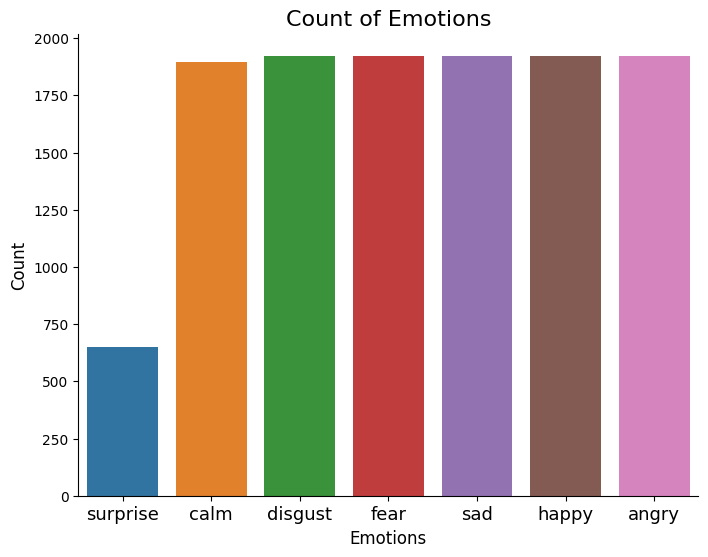

In [26]:
# Plot to see counts of labels
plt.figure(figsize=(8 ,6))
plt.title('Count of Emotions', size=16)
# Google drive plot
# sns.countplot(data=data_df, x="Emotions", hue="Emotions", palette="twilight", legend=False)
# Kaggle plot
sns.countplot(data=data_df, x="Emotions")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tick_params(axis='x', labelsize=13)
plt.show()

Now we will plot waveplots and spectrograms for an instance of each emotion

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectrograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It's a representation of frequencies changing with respect to time for given audio/music signals.

In [27]:
# Function to plot waveform
def create_waveplot(data, sr, emo):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emo} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel('Time(s)', size=12)
    plt.ylabel('Amplitude', size=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()

# Function to plot spectrogram
def create_spectrogram(data, sr, emo):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    # Convert frequency into decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(11, 3))
    plt.title(f'Spectrogram for audio with {emo} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.xlabel('Time(s)', size=12)
    plt.ylabel('Hz', size=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.colorbar()

# Combine all plot functions
def combine_plots(data, emo):
    # Randomly select data instance of given emotion
    data_path = data[data['Emotions'] == emo]['Path'].iloc[randrange(len(data[data['Emotions'] == emo]))]
    data, sr = librosa.load(data_path)
    create_waveplot(data, sr, emo)
    create_spectrogram(data, sr, emo)
    return data, sr

## Calm

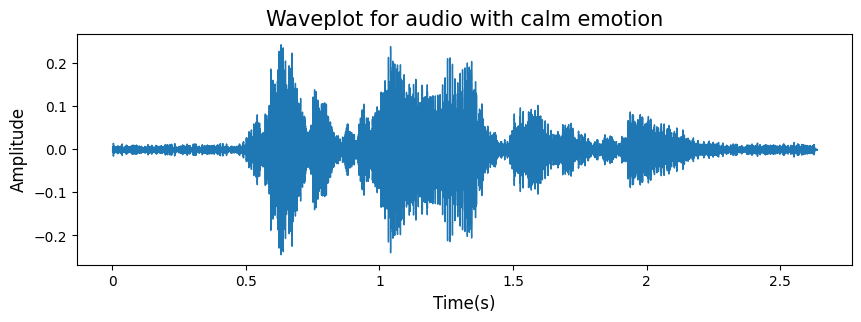

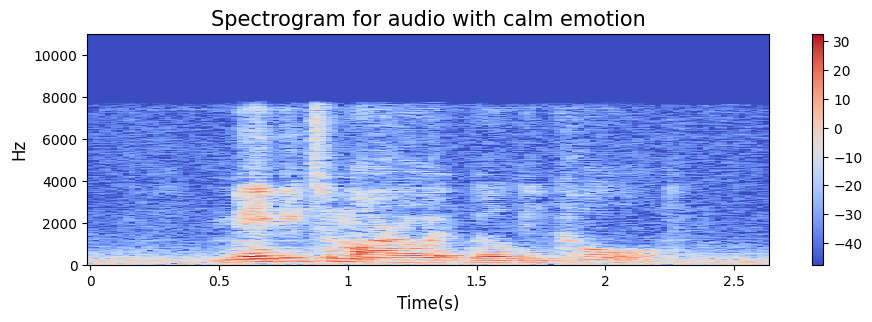

In [28]:
emo = 'calm'
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Surprise

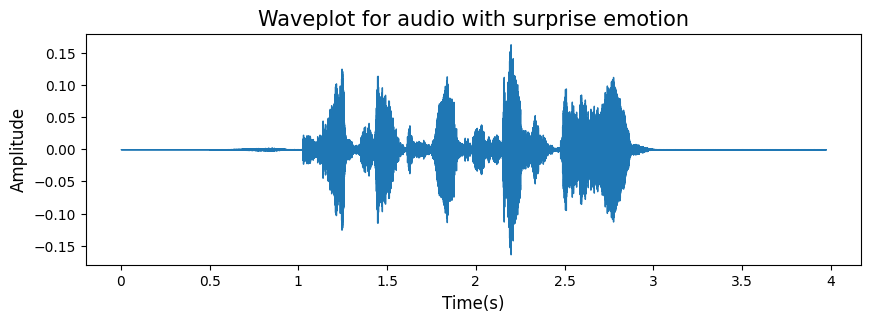

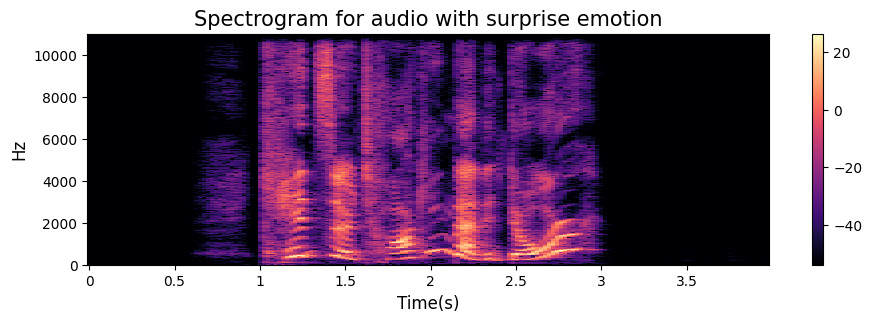

In [29]:
emo = "surprise"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Happy

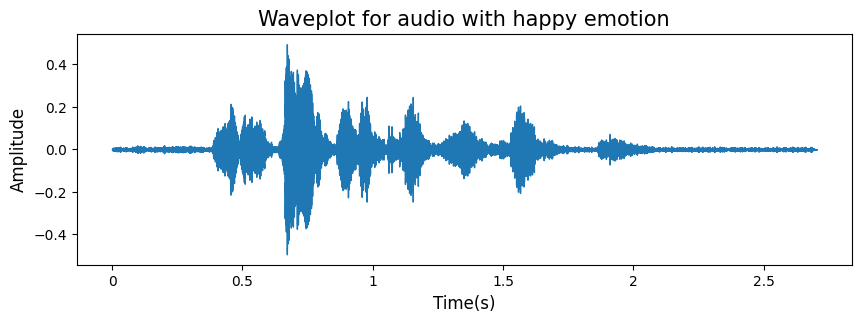

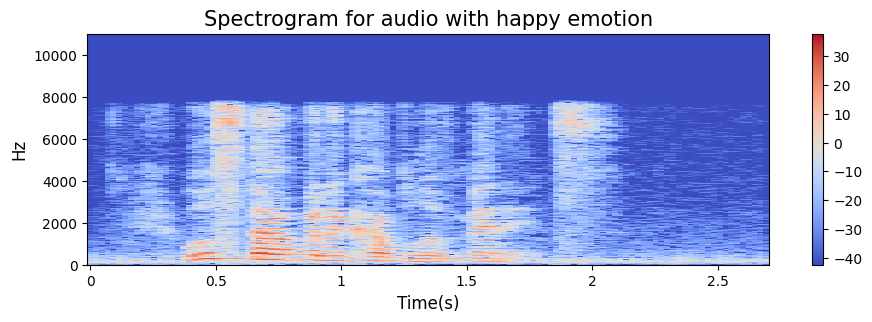

In [30]:
emo = "happy"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Disgust

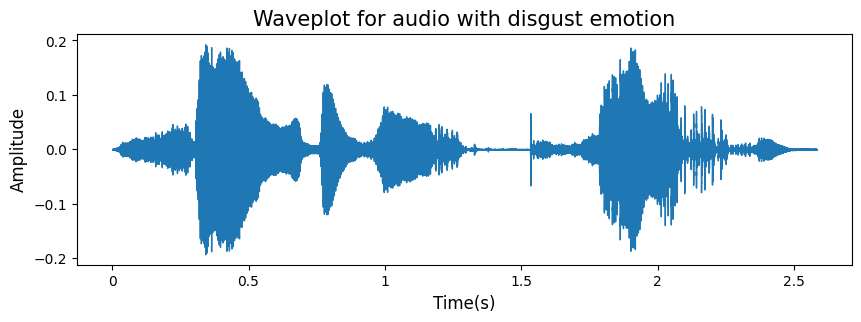

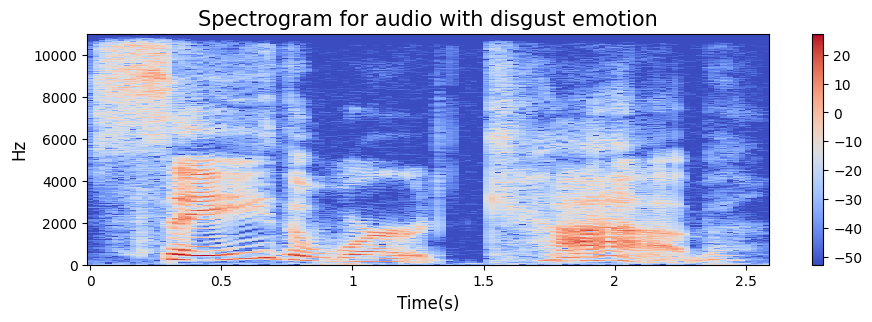

In [31]:
emo = "disgust"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Sad

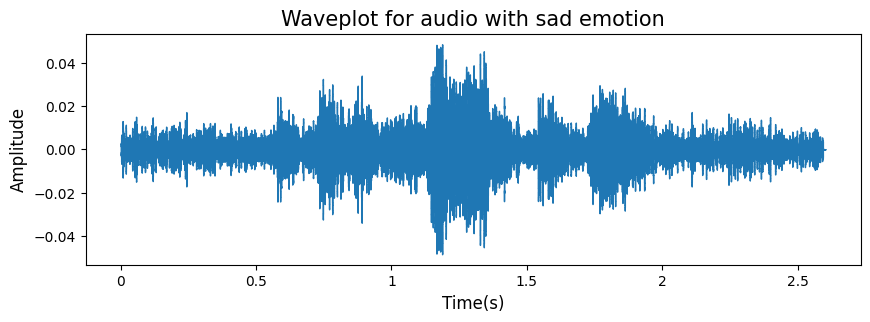

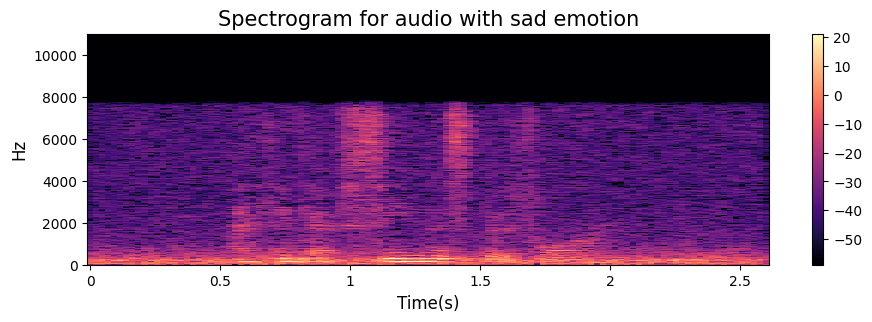

In [32]:
emo = "sad"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Anger

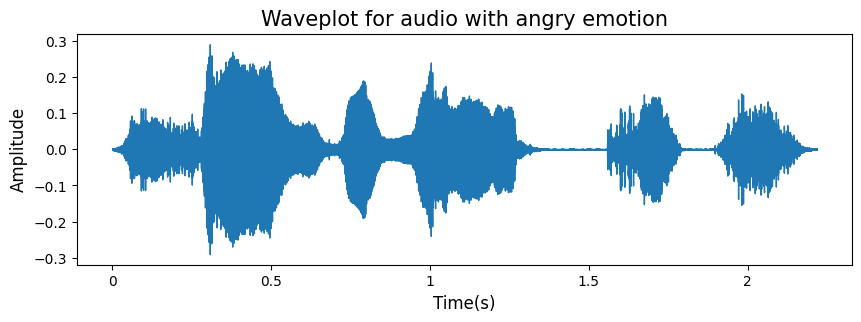

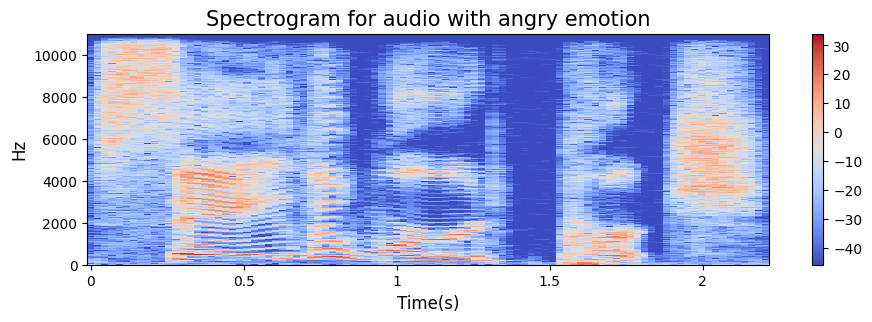

In [33]:
emo = "angry"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

## Fear

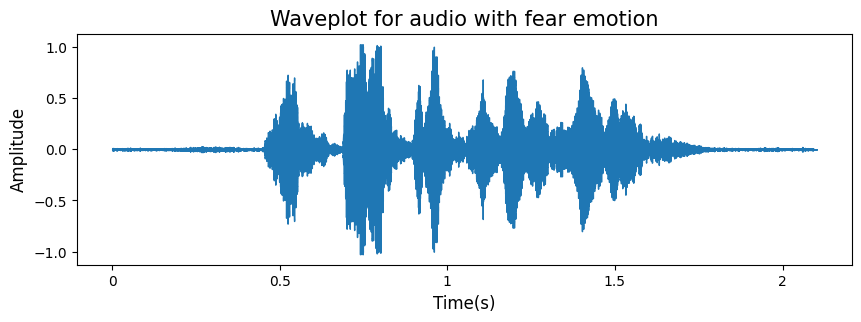

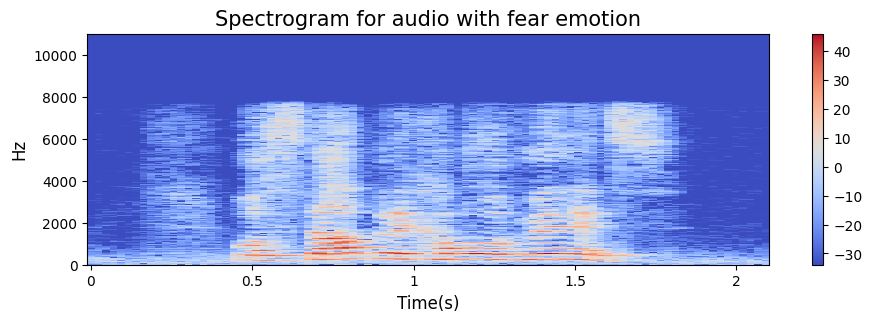

In [34]:
emo = "fear"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

# Data Augmentation

In [35]:
# Function to introduce noise in the audio
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data
# Function to stretch audio
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Function to change the pitch of the data
def pitch(data, sample_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_factor)

In [36]:
# Sample audio path for demonstration
path = data_df['Path'].iloc[randrange(len(data_df))]
data, sample_rate = librosa.load(path)

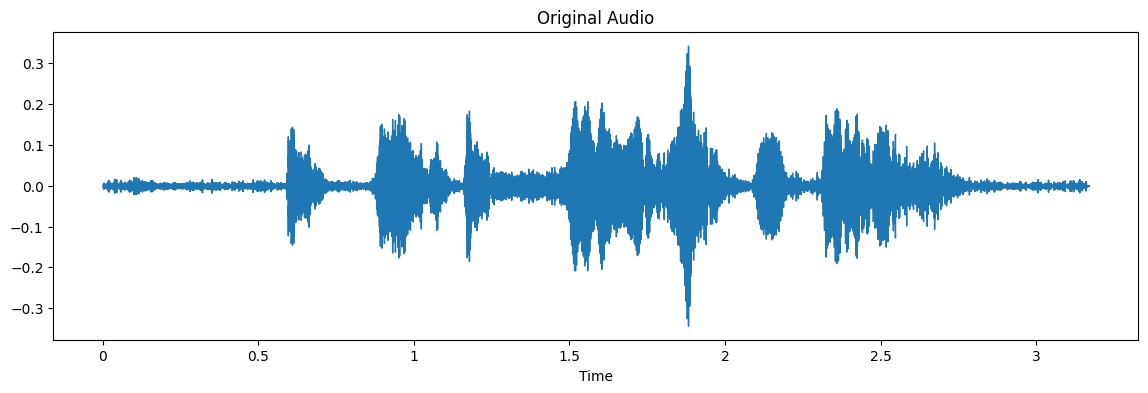

In [37]:
# Simple Audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title('Original Audio')
plt.show()
display(Audio(data, rate=sample_rate))

## Noise Injection

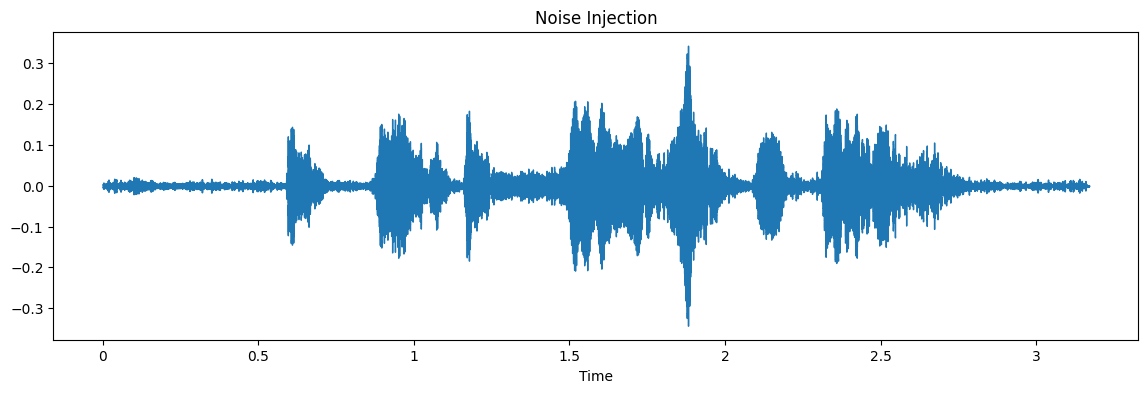

In [38]:
# Introducing noise in audio file
x = noise(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Noise Injection')
plt.show()
Audio(x, rate=sample_rate)

## Stretching

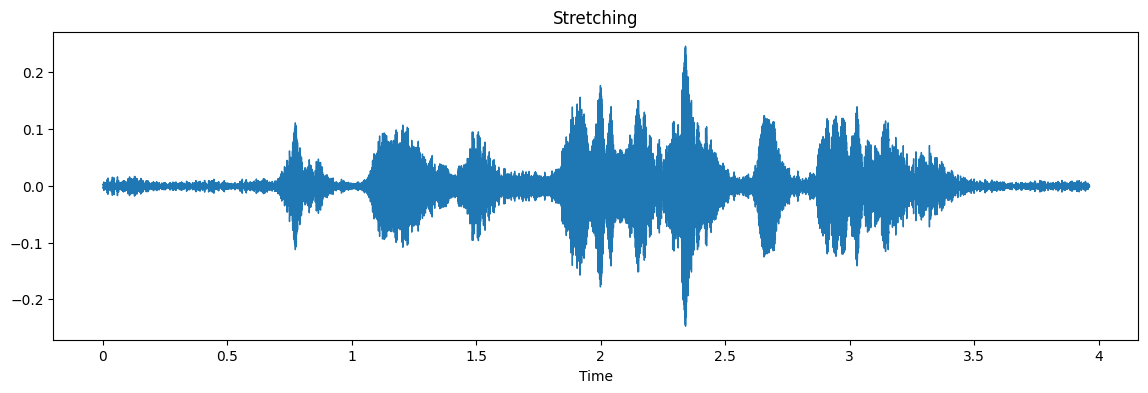

In [39]:
# Stretching the audio file
x = stretch(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Stretching')
plt.show()
display(Audio(x, rate=sample_rate))

## Pitch Shift

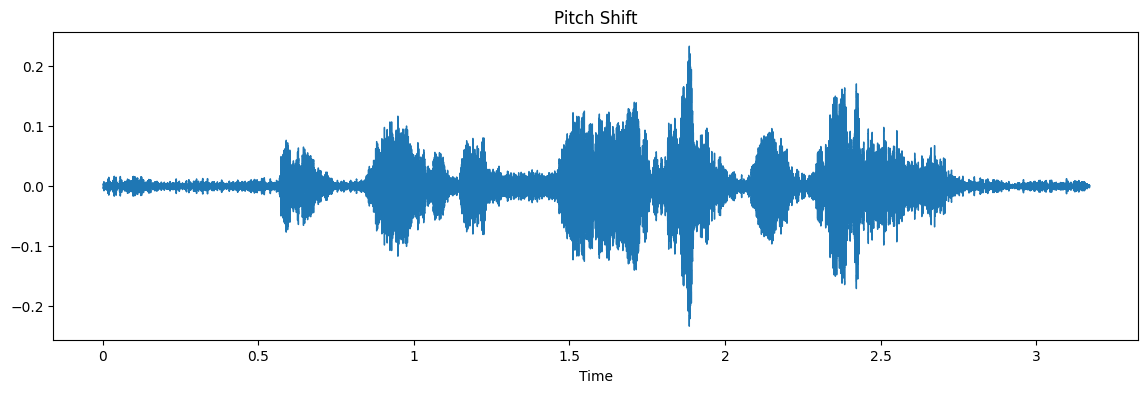

In [40]:
# Shifting the pitch of audio file
x = pitch(data, sample_rate)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Pitch Shift')
plt.show()
display(Audio(x, rate=sample_rate))

# Feature Extraction

We will work with the following features:
* MFCCs: Capture detailed spectral information and are widely used in speech and audio processing.
* Energy and Entropy of Energy: Provide information about the intensity and variability of speech, which are important for detecting emotions.
* Zero Crossing Rate: Useful for distinguishing between different types of speech sounds.
* Mel-Spectrogram: Represents the power spectrum in the mel scale. Captures both temporal and spectral features of the audio signal.
* Spectral Features (Centroid, Spread, Roll-off): Provide a comprehensive description of the spectral characteristics of the speech signal.

In [42]:
# Function to extract features
def extract_features(data, sample_rate):
    # MFCCs
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

    # Energy
    energy = np.mean(librosa.feature.rms(y=data).T, axis=0)

    # Entropy of energy (computed as entropy of the short-term energy)
    st_energy = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)
    entropy_of_energy = np.mean([scipy.stats.entropy(e) for e in st_energy])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

    # Mel-Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

    # Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)

    # Spectral Spread
    spectral_spread = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)

    # Spectral Roll-off
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)

    # Concatenate all features
    features = np.hstack((mfcc, energy, entropy_of_energy, zcr, mel, spectral_centroid, spectral_spread, spectral_rolloff))
    return features

# Function to apply extract_features on data
def get_features(path):
  data, sample_rate = librosa.load(path, duration=3, offset=0.3)

  # Simple Audio
  simple = extract_features(data, sample_rate)

  # Noisy audio
  noisy = extract_features(noise(data), sample_rate)

  # Stretching
  stretched = extract_features(stretch(data), sample_rate)

  # Pitch shifting
  pitch_shifted = extract_features(pitch(data, sample_rate), sample_rate)

  # Concatenate
  features = np.vstack((simple, noisy, stretched, pitch_shifted))
  return features

In [3]:
def process_file(path, emotion):
    features = get_features(path)
    return [(feature, emotion) for feature in features]

In [4]:
X, y = [], []
c = 0
# Use ThreadPoolExecutor for I/O bound tasks or ProcessPoolExecutor for CPU bound tasks
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Create a list of futures
    futures = [executor.submit(process_file, path, emotion) for path, emotion in zip(data_df.Path, data_df.Emotions)]

    # As each future completes, process the results
    for future in concurrent.futures.as_completed(futures):
        results = future.result()
        for feature, emotion in results:
            X.append(feature)
            y.append(emotion)
            c += 1
        print(f"Processed {c} files")

NameError: name 'concurrent' is not defined

In [2]:
# Length of features and labels
len(X), len(y)

NameError: name 'X' is not defined

In [46]:
# Create dataframe of features and labels
data_df = pd.DataFrame(X)
data_df["Labels"] = y
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,Labels
0,-577.653564,61.826630,-15.273873,4.138396,-7.510287,-5.194289,-8.042456,-12.414202,-7.003881,-2.752553,...,0.000042,0.000050,0.000040,0.000052,0.000030,2.271983e-06,3159.079908,2375.311949,5626.129056,calm
1,-344.928913,18.414609,-0.802437,-2.288715,-2.859795,-3.601010,-5.676487,-6.774261,-5.677100,-2.179143,...,0.000549,0.000574,0.000531,0.000557,0.000549,5.108452e-04,4588.514652,3171.672402,8506.194974,calm
2,-598.366333,60.540955,-16.443869,3.329983,-7.278089,-4.975887,-9.493478,-13.549517,-7.606253,-2.901350,...,0.000021,0.000021,0.000016,0.000024,0.000013,1.032033e-06,3164.119980,2406.382405,5662.169054,calm
3,-602.476624,60.411018,-17.089645,2.827656,-9.865584,-6.383657,-11.024261,-13.450514,-7.103153,-3.539668,...,0.000037,0.000018,0.000025,0.000013,0.000007,9.535615e-07,3192.413282,2410.709984,5714.249549,calm
4,-458.276428,18.596369,-32.404045,-5.951672,-14.351929,-15.197365,-10.330965,-16.159365,-8.365202,-6.819104,...,0.002178,0.002024,0.001335,0.002114,0.002426,1.997057e-04,3237.290542,2433.666021,5737.025053,fear


# Data Preprocessing

In [47]:
# Check for null values
print(f"Null values in dataframe: {sum(data_df.isnull().sum())}")
print(f"Shape of dataframe: {data_df.shape}")

Null values in dataframe: 4
Shape of dataframe: (48648, 155)


In [48]:
# Drop null values
data_df.dropna(inplace=True)
print(f"Null values in dataframe: {sum(data_df.isnull().sum())}")
print(f"Shape of dataframe: {data_df.shape}")

Null values in dataframe: 0
Shape of dataframe: (48644, 155)


In [49]:
# Check value of counts of labels
data_df.Labels.value_counts()

Labels
fear        7692
disgust     7692
happy       7692
angry       7692
sad         7688
calm        7580
surprise    2608
Name: count, dtype: int64

In [50]:
# Handle imbalanced label "surprise" by creating fake data instances
# Synthetic Minority Over-sampling Technique (SMOTE)

from imblearn.over_sampling import SMOTE
data_df.columns = data_df.columns.astype(str)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(data_df.iloc[:,:-1], data_df["Labels"])

In [51]:
# Check length of resampled data
len(X_resampled), len(y_resampled)

(53844, 53844)

In [52]:
# Recreate dataframe using resampled data
data_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,Labels
0,-577.653564,61.826630,-15.273873,4.138396,-7.510287,-5.194289,-8.042456,-12.414202,-7.003881,-2.752553,...,0.000042,0.000050,0.000040,0.000052,0.000030,2.271983e-06,3159.079908,2375.311949,5626.129056,calm
1,-344.928913,18.414609,-0.802437,-2.288715,-2.859795,-3.601010,-5.676487,-6.774261,-5.677100,-2.179143,...,0.000549,0.000574,0.000531,0.000557,0.000549,5.108452e-04,4588.514652,3171.672402,8506.194974,calm
2,-598.366333,60.540955,-16.443869,3.329983,-7.278089,-4.975887,-9.493478,-13.549517,-7.606253,-2.901350,...,0.000021,0.000021,0.000016,0.000024,0.000013,1.032033e-06,3164.119980,2406.382405,5662.169054,calm
3,-602.476624,60.411018,-17.089645,2.827656,-9.865584,-6.383657,-11.024261,-13.450514,-7.103153,-3.539668,...,0.000037,0.000018,0.000025,0.000013,0.000007,9.535615e-07,3192.413282,2410.709984,5714.249549,calm
4,-458.276428,18.596369,-32.404045,-5.951672,-14.351929,-15.197365,-10.330965,-16.159365,-8.365202,-6.819104,...,0.002178,0.002024,0.001335,0.002114,0.002426,1.997057e-04,3237.290542,2433.666021,5737.025053,fear


In [53]:
# Check value counts of each label in new dataframe
data_df.Labels.value_counts()

Labels
calm        7692
fear        7692
disgust     7692
sad         7692
surprise    7692
happy       7692
angry       7692
Name: count, dtype: int64

# Data Preparation

In [54]:
# Import necessary libraries for scaling and splitting
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [55]:
# Preparing the features and labels
X = data_df.iloc[:, :-1].values
y = data_df['Labels'].values

In [56]:
# One-hot encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

In [57]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)

In [58]:
# Printing the shapes of the split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40383, 154) (40383, 7) (13461, 154) (13461, 7)


In [59]:
# Scaling the data using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
# Printing the shapes of the scaled data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40383, 154) (40383, 7) (13461, 154) (13461, 7)


# Basic ANN Model

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [47]:
model1 = Sequential([
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

In [48]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
history1 = model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), validation_batch_size=32, validation_steps=len(X_test)//32)

Epoch 1/100

1262/1262 [==============================] - 9s 4ms/step - loss: 1.4074 - accuracy: 0.4437 - val_loss: 1.2546 - val_accuracy: 0.4973

Epoch 2/100

1262/1262 [==============================] - 7s 5ms/step - loss: 1.1865 - accuracy: 0.5339 - val_loss: 1.1410 - val_accuracy: 0.5521

Epoch 3/100

1262/1262 [==============================] - 6s 5ms/step - loss: 1.0934 - accuracy: 0.5706 - val_loss: 1.0518 - val_accuracy: 0.5934

Epoch 4/100

1262/1262 [==============================] - 6s 5ms/step - loss: 1.0440 - accuracy: 0.5906 - val_loss: 1.0190 - val_accuracy: 0.6008

Epoch 5/100

1262/1262 [==============================] - 5s 4ms/step - loss: 1.0106 - accuracy: 0.5996 - val_loss: 1.0036 - val_accuracy: 0.6049

Epoch 6/100

1262/1262 [==============================] - 6s 4ms/step - loss: 0.9823 - accuracy: 0.6122 - val_loss: 0.9655 - val_accuracy: 0.6174

Epoch 7/100

1262/1262 [==============================] - 7s 6ms/step - loss: 0.9631 - accuracy: 0.6189 - val_loss: 0.

# Basic CNN Model

In [50]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

# Define the CNN model
model2 = Sequential()
model2.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(7, activation='softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), validation_batch_size=32, validation_steps=len(X_test)//32)

Epoch 1/100

1262/1262 [==============================] - 18s 9ms/step - loss: 1.3788 - accuracy: 0.4593 - val_loss: 2.9105 - val_accuracy: 0.2393

Epoch 2/100

1262/1262 [==============================] - 11s 9ms/step - loss: 1.1302 - accuracy: 0.5618 - val_loss: 1.6570 - val_accuracy: 0.4306

Epoch 3/100

1262/1262 [==============================] - 11s 9ms/step - loss: 1.0545 - accuracy: 0.5925 - val_loss: 1.8604 - val_accuracy: 0.4675

Epoch 4/100

1262/1262 [==============================] - 11s 9ms/step - loss: 0.9880 - accuracy: 0.6143 - val_loss: 1.1756 - val_accuracy: 0.5433

Epoch 5/100

1262/1262 [==============================] - 12s 10ms/step - loss: 0.9485 - accuracy: 0.6296 - val_loss: 1.1361 - val_accuracy: 0.5692

Epoch 6/100

1262/1262 [==============================] - 10s 8ms/step - loss: 0.9158 - accuracy: 0.6447 - val_loss: 0.9305 - val_accuracy: 0.6308

Epoch 7/100

1262/1262 [==============================] - 12s 9ms/step - loss: 0.8805 - accuracy: 0.6571 - val_